# Image Features
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

In [2]:
import random
import numpy as np
from dl4cv.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk. However, we don't apply our previous preprocessing steps, as we want to extract custom features later on.

Train data shape:  (48000, 32, 32, 3)
Train labels shape:  (48000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


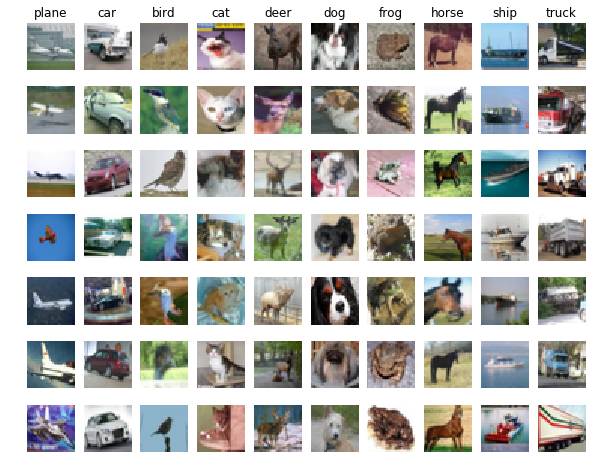

In [3]:
from dl4cv.data_utils import load_CIFAR10
from dl4cv.vis_utils import visualize_cifar10

def get_CIFAR10_data(num_training=48000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for feature extraction and training.
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'datasets/'
    X, y = load_CIFAR10(cifar10_dir)
    

    # Our training set will be the first num_train points from the original
    # training set.
    mask = range(num_training)
    X_train = X[mask]
    y_train = y[mask]
    
    # Our validation set will be num_validation points from the original
    # training set.
    mask = range(num_training, num_training + num_validation)
    X_val = X[mask]
    y_val = y[mask]
    
    # We use a small subset of the training set as our test set.
    mask = range(num_training + num_validation, num_training + num_validation + num_test)
    X_test = X[mask]
    y_test = y[mask]

    return X, y, X_train, y_train, X_val, y_val, X_test, y_test

# Invoke the above function to get our data.
X_raw, y_raw, X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

# visualize raw data
visualize_cifar10(X_raw, y_raw)

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from dl4cv.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 48000 images
Done extracting features for 2000 / 48000 images
Done extracting features for 3000 / 48000 images
Done extracting features for 4000 / 48000 images
Done extracting features for 5000 / 48000 images
Done extracting features for 6000 / 48000 images
Done extracting features for 7000 / 48000 images
Done extracting features for 8000 / 48000 images
Done extracting features for 9000 / 48000 images
Done extracting features for 10000 / 48000 images
Done extracting features for 11000 / 48000 images
Done extracting features for 12000 / 48000 images
Done extracting features for 13000 / 48000 images
Done extracting features for 14000 / 48000 images
Done extracting features for 15000 / 48000 images
Done extracting features for 16000 / 48000 images
Done extracting features for 17000 / 48000 images
Done extracting features for 18000 / 48000 images
Done extracting features for 19000 / 48000 images
Done extracting features for 20000 / 48000 images
Done extr

## Train a Softmax classifier on features
Using the multiclass Softmax code developed earlier in the assignment, train a Softmax classifier on top of the features extracted above; this should achieve better results than training the classifier directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from dl4cv.classifiers.linear_classifier import Softmax

learning_rates = [1e-9, 1e-8, 1e-7]
regularization_strengths = [1e5, 1e6, 1e7]

results = {}
best_val = -1
best_softmax = None


################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the Softmax; save#
# the best trained classifer in best_softmax. You might also want to play      #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################

best_comb = {}
for lr in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss_hist = softmax.train(X_train_feats, y_train, learning_rate=lr, reg=reg,
                      num_iters=1200, verbose=True)
        y_train_pred = softmax.predict(X_train_feats)
        training_accuracy = np.mean(y_train == y_train_pred)
        print('training accuracy: %f' % training_accuracy, )
        y_val_pred = softmax.predict(X_val_feats)
        validation_accuracy = np.mean(y_val == y_val_pred)
        print('validation accuracy: %f' % validation_accuracy, )
        results.update({(lr, reg):(training_accuracy, validation_accuracy)})
        if validation_accuracy > best_val:
            best_val = validation_accuracy
            best_comb = {"training accuracy": training_accuracy, "validation_accuracy":validation_accuracy, "softmax_obj":softmax, "lr": lr, "reg": reg}

################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
          lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during validation: %f' % best_val)

iteration 0 / 1200: loss 79.180927
iteration 100 / 1200: loss 77.613316
iteration 200 / 1200: loss 76.076588
iteration 300 / 1200: loss 74.570323
iteration 400 / 1200: loss 73.093924
iteration 500 / 1200: loss 71.646660
iteration 600 / 1200: loss 70.228193
iteration 700 / 1200: loss 68.837682
iteration 800 / 1200: loss 67.474917
iteration 900 / 1200: loss 66.138912
iteration 1000 / 1200: loss 64.829330
iteration 1100 / 1200: loss 63.545890
training accuracy: 0.101271
validation accuracy: 0.093000
iteration 0 / 1200: loss 847.190213
iteration 100 / 1200: loss 693.553377
iteration 200 / 1200: loss 567.778763
iteration 300 / 1200: loss 464.813438
iteration 400 / 1200: loss 380.521128
iteration 500 / 1200: loss 311.515296
iteration 600 / 1200: loss 255.023722
iteration 700 / 1200: loss 208.776950
iteration 800 / 1200: loss 170.917123
iteration 900 / 1200: loss 139.923207
iteration 1000 / 1200: loss 114.550048
iteration 1100 / 1200: loss 93.778366
training accuracy: 0.096083
validation accu

In [6]:
print(best_comb)

{'training accuracy': 0.17602083333333332, 'validation_accuracy': 0.20100000000000001, 'softmax_obj': <dl4cv.classifiers.linear_classifier.Softmax object at 0x11d54a048>, 'lr': 1e-08, 'reg': 10000000.0}


In [7]:
bsoftmax = best_comb["softmax_obj"]
best_comb["softmax_obj"].train(X_train_feats, y_train, learning_rate=best_comb["lr"], reg=best_comb["reg"],
                      num_iters=1500, verbose=True)
y_train_pred = bsoftmax.predict(X_train_feats)
training_accuracy = np.mean(y_train == y_train_pred)
print('training accuracy: %f' % training_accuracy, )
y_val_pred = bsoftmax.predict(X_val_feats)
validation_accuracy = np.mean(y_val == y_val_pred)
print('validation accuracy: %f' % validation_accuracy, )

# Evaluate your trained classifier on the test set
y_test_pred = bsoftmax.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

iteration 0 / 1500: loss 0.011571
iteration 100 / 1500: loss 0.011571
iteration 200 / 1500: loss 0.011571
iteration 300 / 1500: loss 0.011571
iteration 400 / 1500: loss 0.011571
iteration 500 / 1500: loss 0.011571
iteration 600 / 1500: loss 0.011571
iteration 700 / 1500: loss 0.011571
iteration 800 / 1500: loss 0.011571
iteration 900 / 1500: loss 0.011571
iteration 1000 / 1500: loss 0.011571
iteration 1100 / 1500: loss 0.011571
iteration 1200 / 1500: loss 0.011571
iteration 1300 / 1500: loss 0.011571
iteration 1400 / 1500: loss 0.011571
training accuracy: 0.200875
validation accuracy: 0.190000
0.194


0.24


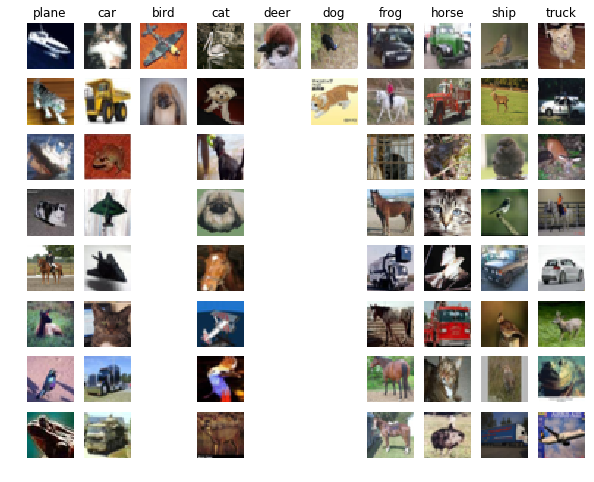

In [8]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    if len(idxs) > 0:
        idxs = np.random.choice(idxs, min(examples_per_class, len(idxs)), replace=False)
    else:
        idxs = []
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe the misclassification results that you see. Do they make sense?</p>
</div>

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set.

Note that in the neural net class we have used explicit biases. In the preprocessing of this exercise we have also added a bias dimension to the input, such that we don't have to consider an explicit bias in the linear classifier above. The neural net therefore has an additional parameter in the first layer (the additional bias term), which after all does not matter, as both bias terms can be learned. So just don't get confused by this.

In [9]:
from dl4cv.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
net = TwoLayerNet(input_dim, hidden_dim, num_classes)
# Train the network
stats = net.train(X_train_feats, y_train, X_val_feats, y_val,
num_iters=5000, batch_size=256,
learning_rate=0.9, learning_rate_decay=0.95,
reg=1e-3, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val_feats) == y_val).mean()
print('Validation accuracy: ', val_acc)

best_net = net
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

iteration 0 / 5000: loss 2.302586
iteration 100 / 5000: loss 1.437466
iteration 200 / 5000: loss 1.407753
iteration 300 / 5000: loss 1.169683
iteration 400 / 5000: loss 1.361539
iteration 500 / 5000: loss 1.119999
iteration 600 / 5000: loss 1.289394
iteration 700 / 5000: loss 1.172993
iteration 800 / 5000: loss 1.132424
iteration 900 / 5000: loss 1.042665
iteration 1000 / 5000: loss 1.112817
iteration 1100 / 5000: loss 1.031925
iteration 1200 / 5000: loss 0.962096
iteration 1300 / 5000: loss 1.014112
iteration 1400 / 5000: loss 0.978407
iteration 1500 / 5000: loss 0.943709
iteration 1600 / 5000: loss 0.968235
iteration 1700 / 5000: loss 1.006396
iteration 1800 / 5000: loss 0.939028
iteration 1900 / 5000: loss 0.823052
iteration 2000 / 5000: loss 1.042132
iteration 2100 / 5000: loss 0.951842
iteration 2200 / 5000: loss 0.920422
iteration 2300 / 5000: loss 0.774751
iteration 2400 / 5000: loss 0.987787
iteration 2500 / 5000: loss 0.930243
iteration 2600 / 5000: loss 0.888303
iteration 270

In [10]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.

test_acc = (net.predict(X_test_feats) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.608


## Save the model

When you are satisfied with your training, save the model for submission.

In [11]:
from dl4cv.model_savers import save_feature_neural_net
save_feature_neural_net(best_net)

## Scoring function
We will score the model you have just saved based on the classification accuracy on our test dataset. The scoring function should represent the difficulty of obtaining a good test accuracy and should therefore give 0 points for worse results than random guessing, should be linear in a first regime and exponential beyond that. The onset of exponential growth depends on the problem. In that region you get twice as many points for an additional 10% accuracy.

For this problem we specifically use the following scoring function:

$$f(x) = \left\{
	\begin{array}{ll}
		0  & \mbox{if } x \leq 0.1 \\
		100x & \mbox{if } 0.1 < x \leq 0.59 \\
        \left(\frac{59}{\exp(0.59 \ln(2)/0.1)}\right) \exp(x \ln(2)/0.1) & \mbox{if } 0.59 < x \leq 1
	\end{array}
\right.$$

The function can be plotted in the following cell.

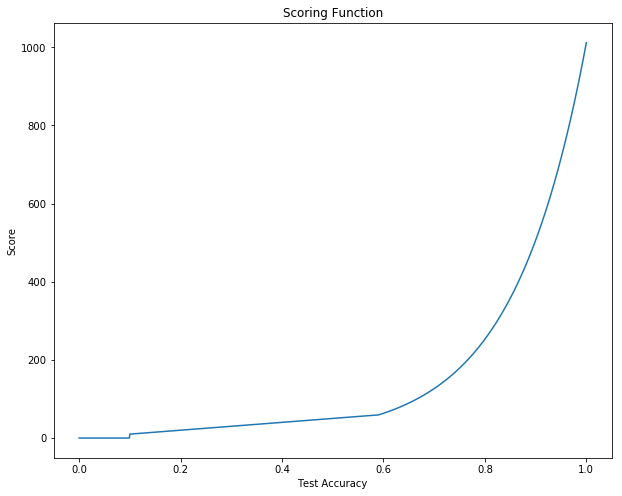

In [12]:
from dl4cv.data_utils import scoring_function

x = np.linspace(0, 1, num=1000)
plt.plot(x, scoring_function(x, lin_exp_boundary=0.59, doubling_rate=0.1))
plt.title('Scoring Function')
plt.xlabel('Test Accuracy')
plt.ylabel('Score')
plt.show()